In [1]:
# Libraries import and settings

from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNetCV, ElasticNet, Lasso, LassoCV

line_sep = '------------------------------------------------------------------'
cv = 8

In [2]:
# Color palette function that defines color from y values

def colors_func(values, std_palette, color_steps):
    normalized = (values - min(values)) / (max(values) - min(values)) # normalize the values to range [0, 1]
    indices = np.round(normalized * (color_steps - 1)).astype(np.int32) # convert to indices
    palette = sns.color_palette(std_palette, color_steps) # use the indices to get the colors
    return np.array(palette).take(indices, axis = 0)

# Profiling of the spending power of italian families

### *Fabrizio Boffa - May 2021*

## Main objective

The goal of this study is to comprehend italian families spend capability.<br>
We will use some variations of linear regression model to measure how some characteristics influence italian families total monthly spend.
Given that, the analysis presented in the next paragraphs are focused on interpretation rather than prediction.

## Data

Our analysis will be based entirely on the latest "Household Budget Survey" (HBS) from the Italian National Institute of Statistics (ISTAT).

ISTAT is a public research organisation, is the main producer of official statistics in the service of citizens and policy-makers. It operates in complete independence and continuous interaction with the academic and scientific communities.

HBS is a sample survey conducted every month of the year, focused on consumption expenditure behaviors of the Italian resident households.<br>
The main target of the HBS is represented by all expenditures incurred by resident households to purchase goods and services exclusively devoted to household consumption (self-consumptions, imputed rentals and presents are included); every other expenditure for a different purpose is excluded from the data collection.

Below, a note on the dataset dimension.

In [3]:
# Import data

zf = ZipFile('data\HBS_Microdati_2019.zip')
df_source = pd.read_csv(
    zf.open('HBS_Microdati_2019.txt'),
    '\t',
    na_values = [' ', ' .', '.', '  .', '  '],
)
zf.close()

In [4]:
# Dataset dimension

# Final dataset shape

print(line_sep)
print('Source dataset has {} features and {} observations'.format(df_source.shape[1], df_source.shape[0]))
print(line_sep)

------------------------------------------------------------------
Source dataset has 1323 features and 18718 observations
------------------------------------------------------------------


## Data exploration and features engineering

Each observation in the dataset is a single family.

Looking at the features, we can identify three main sections:

1. family profiling ($\approx$ 300 features)
2. detailed spend features ($\approx$ 1000 features)
3. aggregated spend features ($\approx$ 30 features)

In this study we will focus on family profiling and aggregated spend features.

In particular, among the aggregated features, we will consider just the grand total spend as the dependant variable.

As independent variables, we will pick the most significant features among the first group that may possibly affect the dependant variable.

The vast majority of the family profiling features are in a raw format that valorize each characteristics for each family component. Indeed, for each family member we have about ten specific features that assess characteristics such as sex, age, study level, etc.

We need then to transform these features defined "per family component" to "overall family" features. To do so we will simply count how many member of that family present a given feature and store the value, as a new feature, in a new dataframe we will use for analysis. Doing so, we will end up having more useful "per family" data such as how many components are male, aged less than 18 or high school graded. <br>
Precisley we will elaborate family data about:

- Sex composition (2 family features)
- Age composition (4 family features)
- Study level composition (5 family features)
- Occupation composition (4 family features)
- Income composition (3 family features)
- Working condition composition (4 family features)
- Economic sector composition (3 family features)

Before collecting the data we need to account for multicollinearity, since we will use linear regression models that are very sensible to this problem.<br>
For example the age data are collected "per family member" in four ranges:
1. less than 18
2. between 18 and 34 
3. between 35 and 64
4. 65 and more

Translating these information in "per family data", we end up having four family features counting how many family member are less than 18, between 18 and 34, between 35 and 64 or 65 and more. Since it's impossible that a family component is not into one of these ranges, we can't use all four features because three of them are sufficient to obtain the fourth. So we drop the first range and use the other three as family features.<br>

To better assess the problem we have run an algorithm that checked for every characteristic if there are unlabeled family components. Below a report:

In [5]:
# check family composition data structure

start = time.time()

family_composition_features = np.array([
    ['sesso_1', 'sesso_2', 'sesso_3', 'sesso_4', 'sesso_5', 'sesso_6'],
    ['c_c_etacalc_1', 'c_c_etacalc_2', 'c_c_etacalc_3', 'c_c_etacalc_4', 'c_c_etacalc_5', 'c_c_etacalc_6'],
    ['c_titstu_1', 'c_titstu_2', 'c_titstu_3', 'c_titstu_4', 'c_titstu_5', 'c_titstu_6'],
    ['c_pospro_1', 'c_pospro_2', 'c_pospro_3', 'c_pospro_4', 'c_pospro_5', 'c_pospro_6'],
    ['c_c_redd_1', 'c_c_redd_2', 'c_c_redd_3', 'c_c_redd_4', 'c_c_redd_5', 'c_c_redd_6'],
    ['c_cond_1', 'c_cond_2', 'c_cond_3', 'c_cond_4', 'c_cond_5', 'c_cond_6'],
    ['c_ateco_1', 'c_ateco_2', 'c_ateco_3', 'c_ateco_4', 'c_ateco_5', 'c_ateco_6'],
])

family_sizes = []
ages = []
studies = []
occupations = []
income = []
cond = []
economy_sector = []


for row in df_source.iterrows():
    count = 0
    for feature in family_composition_features[0]:
        if ~np.isnan(row[1][feature]):
            count += 1
    family_sizes.append(count)
    count = 0
    for feature in family_composition_features[1]:
        if ~np.isnan(row[1][feature]):
            count += 1
    ages.append(count)
    count = 0
    for feature in family_composition_features[2]:
        if ~np.isnan(row[1][feature]):
            count += 1
    studies.append(count)
    count = 0
    for feature in family_composition_features[3]:
        if ~np.isnan(row[1][feature]):
            count += 1
    occupations.append(count)
    count = 0
    for feature in family_composition_features[4]:
        if ~np.isnan(row[1][feature]):
            count += 1
    income.append(count)    
    count = 0
    for feature in family_composition_features[5]:
        if ~np.isnan(row[1][feature]):
            count += 1
    cond.append(count)
    count = 0
    for feature in family_composition_features[6]:
        if ~np.isnan(row[1][feature]):
            count += 1
    economy_sector.append(count)   
            
df_NC = pd.DataFrame(
    data = np.array(
        [
            np.array(family_sizes) - np.array(ages),
            np.array(family_sizes) - np.array(studies),
            np.array(family_sizes) - np.array(occupations),
            np.array(family_sizes) - np.array(income),
            np.array(family_sizes) - np.array(cond),
            np.array(family_sizes) - np.array(economy_sector),
        ]
    ).T,
    columns = (
        'Members_not_classified_by_Age',
        'Members_not_classified_by_Study',
        'Members_not_classified_by_Occupation', 
        'Members_not_classified_by_Income',
        'Members_not_classified_by_Condition',
        'Members_not_classified_by_Econmy_Sector',
    ),
)

print(line_sep)
print('*** FAMILY COMPOSITION DATA ANALISYS ***')
print('Verify features with nulls for existing family members')
print("Analisys completed in {:.2f} seconds.".format(time.time() - start))
print(line_sep)

for column in df_NC.columns:
    print(df_NC[column].value_counts())
    print(line_sep)


------------------------------------------------------------------
*** FAMILY COMPOSITION DATA ANALISYS ***
Verify features with nulls for existing family members
Analisys completed in 7.17 seconds.
------------------------------------------------------------------
0    18718
Name: Members_not_classified_by_Age, dtype: int64
------------------------------------------------------------------
0    18718
Name: Members_not_classified_by_Study, dtype: int64
------------------------------------------------------------------
0    9960
1    5257
2    2431
3     812
4     211
5      46
6       1
Name: Members_not_classified_by_Occupation, dtype: int64
------------------------------------------------------------------
0    15210
1     2050
2     1227
3      206
4       25
Name: Members_not_classified_by_Income, dtype: int64
------------------------------------------------------------------
0    15210
1     2050
2     1227
3      206
4       25
Name: Members_not_classified_by_Condition, dtype: in

For each category, on the left we find the number of unlabeled members and on the right the corresponding number of families.
The first category is the age and, as expected, there are no families with unclassified members.

The second category is the study level and, surprisingly, there are no families with unclassified members. Indeed, in the ISTAT survey, there is also the "no study level" classification that we will not translate into a family feature to avoid multicollinearity.

The third category account for the occupation and we can see that many families present more unclassified members. Since one ore more members can be effectively unclassified, we can use all the occupation classifications as family features without worrying about multicollinearity. Same reasoning to the remaining categories in the above report.

Now that we have a deep understanding of the data, we can create the analysis dataframe.

In [6]:
# Family composition data creation parameters

features_list_2D = [
    ['sesso_1', 'sesso_2', 'sesso_3', 'sesso_4', 'sesso_5', 'sesso_6'],
    ['c_c_etacalc_1', 'c_c_etacalc_2', 'c_c_etacalc_3', 'c_c_etacalc_4', 'c_c_etacalc_5', 'c_c_etacalc_6'],
    ['c_titstu_1', 'c_titstu_2', 'c_titstu_3', 'c_titstu_4', 'c_titstu_5', 'c_titstu_6'],
    ['c_pospro_1', 'c_pospro_2', 'c_pospro_3', 'c_pospro_4', 'c_pospro_5', 'c_pospro_6'],
    ['c_c_redd_1', 'c_c_redd_2', 'c_c_redd_3', 'c_c_redd_4', 'c_c_redd_5', 'c_c_redd_6'],
    ['c_cond_1', 'c_cond_2', 'c_cond_3', 'c_cond_4', 'c_cond_5', 'c_cond_6'],
    ['c_ateco_1', 'c_ateco_2', 'c_ateco_3', 'c_ateco_4', 'c_ateco_5', 'c_ateco_6'],
]

columns_list_2D = [
    ['Male', 'Female'],
    ['Age 18-34', 'Age 35-64', 'Age > 65'],
    ['Primary school grade', 'Secondary school grade', 'High school grade', 'College grade'],
    ['Manager', 'Worker', 'Freelance', 'Self employed'],
    ['Work income', 'Retirement income', 'Other income'],
    ['Employed', 'Unemployed', 'Other condition', 'Retired'],
    ['Primary economic sector', 'Secondary economic sector', 'Tertiary economic sector'],
]

values_list_2D = [
    [1, 2],
    [2, 3, 4],
    [2, 3, 4, 5],
    [1, 2, 3, 4],
    [1, 2, 3],
    [1, 2, 3, 4],
    [1, 2, 3],
]

In [7]:
# Family composition data creation algorithm

start = time.time()

columns_list = []
for columns in columns_list_2D:
    columns_list = columns_list + columns

df_data = pd.DataFrame(index = df_source.index, columns = columns_list, dtype = 'float64')

for row in df_source.iterrows():
    for i in range(len(columns_list_2D)):
        for j in range(len(columns_list_2D[i])):
            count = 0
            for feature in features_list_2D[i]:
                if row[1][feature] == values_list_2D[i][j]:
                    count += 1
            df_data.at[row[0], columns_list_2D[i][j]] = count

print(line_sep)
print('*** FAMILY COMPOSITION DATA CREATION ***')
print("Dataset created in {:.2f} seconds.".format(time.time() - start))
print(line_sep)

------------------------------------------------------------------
*** FAMILY COMPOSITION DATA CREATION ***
Dataset created in 13.84 seconds.
------------------------------------------------------------------


Below, we display the analysis dataset just created for the first ten families. For convenience, we have transposed the dataframe so that features are more readable as row headers.

In [8]:
# Analysis dataframe display

df_data.head(10).T.convert_dtypes()

,0,1,2,3,4,5,6,7,8,9
Male,0,2,2,1,3,1,1,2,1,1
Female,1,1,3,1,1,1,1,1,1,2
Age 18-34,0,1,0,0,3,0,0,0,0,2
Age 35-64,0,1,2,0,1,0,0,2,0,1
Age > 65,1,1,0,2,0,2,2,0,2,0
Primary school grade,0,2,1,0,0,0,0,0,0,0
Secondary school grade,0,1,4,1,4,2,1,0,0,1
High school grade,0,0,0,1,0,0,1,2,0,1
College grade,1,0,0,0,0,0,0,0,0,1
Manager,0,0,0,1,0,0,0,2,0,1


We can se, for example, that the first family is composed by one member, female, aged more than 65, college graded. She is retired from work and her primary source of income is retirement.

Basically, all family features can variate discretely between zero, if the feature is not present, and six, in the case that all elements of a six member sized family present that feature. Six is the biggest family size found.

As other features that may influence the italian families spend, thus increasing our model performance, we will include:

- Capability
- Regional GDP per capita
- Home size
- Housing rental
- Housing mortgage

The capability is a self esteem about the families wealth and their economic power divided in four ordinal grades from zero (insufficient) to three (excellent). It is a subjective perception of their self wealthness rather than a measure of the family income. We will treat this feature as a numerical discrete variable. 

The last four are self-explanatory and will be scaled with the Min/Max rule in an interval between zero and three to have a similar scale as the feature mentioned above.

Then we will add the dependant variable, which is the total montly spend to purchase goods and services exclusively devoted to household consumption. Housing rentals and mortgages are not included, of course.<br>
For improved interpretability of the models results, we will keep the dependant variable in its own scale.

Finally we will check and remove rows containing outlier spend values, utilizing Tukey's fences method.

In [9]:
# Add other features and label

start = time.time()

print(line_sep)
print('*** TEST DATASET CREATION ***')


df_data_copy = df_data.copy()

# Fill NaN with 0
df_source.fillna({'c_Superf' : 0}, inplace = True)
df_source.fillna({'X2_29_bf' : 0}, inplace = True)
df_source.fillna({'X2_33_bf' : 0}, inplace = True)

# df_data_copy['Home size'] = np.round(MinMaxScaler((0, 3)).fit_transform(X = df_source[['c_Superf']].values), 0)
# df_data_copy['Housing rental'] = np.round(MinMaxScaler((0, 3)).fit_transform(X = df_source[['X2_29_bf']].values), 0)
# df_data_copy['Housing mortgage'] = np.round(MinMaxScaler((0, 3)).fit_transform(X = df_source[['X2_33_bf']].values), 0)

df_data_copy['Home size'] = MinMaxScaler((0, 3)).fit_transform(X = df_source[['c_Superf']].values)
df_data_copy['Housing rental'] = MinMaxScaler((0, 3)).fit_transform(X = df_source[['X2_29_bf']].values)
df_data_copy['Housing mortgage'] = MinMaxScaler((0, 3)).fit_transform(X = df_source[['X2_33_bf']].values)
df_data_copy['Capability'] = - df_source['Risecon'] + 4.0

dict_gdp = pd.read_csv('data\GDP_pro_capita.csv', sep = ';', decimal = ',', index_col = 0, usecols = [0, 2])['GDP'].to_dict()
df_data_copy['Regional GDP'] = MinMaxScaler((0, 3)).fit_transform(X = df_source[['rgn']].replace(dict_gdp).values)

features = list(df_data_copy.columns)


columns_list_2D.append(['Home size', 'Housing rental', 'Housing mortgage', 'Capability', 'Regional GDP'])

label = 'Spend'
df_data_copy[label] = np.round(df_source['sp_tot_str_aggr_1'], 0)

# Outliers removal (optional)

remove_outliers = True

if remove_outliers:
    
    features_to_check = [label]
    outliers_count = 0
    
    for feature in features_to_check:
        Q1 = np.quantile(df_data_copy[feature].values, 0.25)
        Q3 = np.quantile(df_data_copy[feature].values, 0.75)
        IQR = Q3 - Q1
        k = 1.5
        up_limit = Q3 + k * (Q3 - Q1)
        lo_limit = Q1 - k * (Q3 - Q1)
        index_to_remove = df_data_copy.loc[(df_data_copy[feature] <= lo_limit) | (df_data_copy[feature] >= up_limit)].index
        df_data_copy.drop(index_to_remove, inplace = True)
        outliers_count += len(index_to_remove)
        print('Outliers removed for feature "{}": {}'.format(feature, len(index_to_remove)))
    
    print('Removed {} outliers'.format(outliers_count))
    
# testing array creation

X = df_data_copy[features].values
X_fs = df_data_copy.values
y = df_data_copy[label].values

print("Process completed in {:.2f} seconds.".format(time.time() - start))
print(line_sep)

------------------------------------------------------------------
*** TEST DATASET CREATION ***
Outliers removed for feature "Spend": 771
Removed 771 outliers
Process completed in 0.03 seconds.
------------------------------------------------------------------


Before proceeding to the modeling stage, we will check statistical significance of each independent variable with an F-test.

The Pearson correlation coefficient between each regressor and the dependent variable will be calculated with the formula:

$\displaystyle \rho_{x_{i}, y} = \frac{cov(x_{i}, y)}{\sigma_{x_{i}} \sigma_{y}}$

where:

$x_{i}$ and $\sigma_{X_{i}}$ are respectively the i-th indepandant variable and its standard deviation<br>
$y$ and $\sigma_{y}$ are respectively the depandant variable and its standard deviation<br>
$cov(x_{i}, y)$ is the covariance of $x_{i}$ and $y$<br>

The F statistic for each correlation coefficient is then calculated with the formula:

$\displaystyle F_{i} = \frac{\rho_{x_{i}, y}^{2}}{1 - \rho_{x_{i}, y}^{2}} (n - 2)$

where $n$ is the number of observations. A corresponding P-value is finally derived from each F statistic.

Below a report with the results of the aforementioned process.

In [10]:
# F test

f_reg = f_regression(X, y)

pd.DataFrame(
    columns = ['F', 'p-value'],
    index = df_data_copy[features].columns, 
    data = np.round(np.array((f_reg)).T, 3)
).sort_values('F', ascending = False)

,F,p-value
Manager,3715.478,0.000
Employed,3207.327,0.000
Work income,3126.959,0.000
Tertiary economic sector,2761.143,0.000
College grade,2159.895,0.000
Home size,1898.613,0.000
Age 35-64,1896.491,0.000
Male,1855.683,0.000
High school grade,1836.415,0.000
Capability,1372.567,0.000


The null hypothesis is that the feature is not correlated with the target variable and the results show that only for the "Retired" features the correlation is not statistically significant with a significance level $\alpha < 0.05$.

Thus we will remove this feature to simplify the model.

In [11]:
# Remove non significant features

features_to_remove = ['Retired']

df_data_copy.drop(features_to_remove, axis = 1, inplace = True)
for feature in features_to_remove:
    features.remove(feature)
    for i in range(len(columns_list_2D)):
        try: 
            columns_list_2D[i].remove(feature)
        except:
            pass

# testing array creation
X = df_data_copy[features].values
X_fs = df_data_copy.values
y = df_data_copy[label].values

Below the first ten rows (families) of the final dataset we will use for modeling. Again, for convenience, we have transposed the dataframe so that features are more readable as row headers.

In [12]:
# Study dataset shape

print(line_sep)
print('Study dataset has {} features and {} observations'.format(df_data_copy.shape[1], df_data_copy.shape[0]))
print(line_sep)

np.round(df_data_copy.head(10).T, 1)

------------------------------------------------------------------
Study dataset has 28 features and 17947 observations
------------------------------------------------------------------


,0,1,2,3,4,5,6,7,8,9
Male,0.0,2.0,2.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0
Female,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
Age 18-34,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0
Age 35-64,0.0,1.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0
Age > 65,1.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,2.0,0.0
Primary school grade,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Secondary school grade,0.0,1.0,4.0,1.0,4.0,2.0,1.0,0.0,0.0,1.0
High school grade,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0
College grade,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Manager,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0


In the table below we can see some summary statistics.

In [13]:
# Study dataset info

np.round(df_data_copy.describe().T, 1)

,count,mean,std,min,25%,50%,75%,max
Male,17947.0,1.1,0.8,0.0,1.0,1.0,1.0,5.0
Female,17947.0,1.2,0.8,0.0,1.0,1.0,1.0,5.0
Age 18-34,17947.0,0.3,0.6,0.0,0.0,0.0,1.0,4.0
Age 35-64,17947.0,1.0,0.9,0.0,0.0,1.0,2.0,5.0
Age > 65,17947.0,0.6,0.8,0.0,0.0,0.0,1.0,4.0
Primary school grade,17947.0,0.3,0.6,0.0,0.0,0.0,1.0,5.0
Secondary school grade,17947.0,0.6,0.9,0.0,0.0,0.0,1.0,6.0
High school grade,17947.0,0.7,0.9,0.0,0.0,1.0,1.0,6.0
College grade,17947.0,0.3,0.6,0.0,0.0,0.0,0.0,6.0
Manager,17947.0,0.6,0.8,0.0,0.0,0.0,1.0,5.0


## Three linear regression models

We will start with a baseline linear regression models, we will then add polynomial features with increasing degrees and finally some regularization.

Every model will be cross validated with K-Fold method using eight folds acquired from the entire dataset consecutively. The folds and their content will be the same in all the regression instances.<br>
This will ensure that every model is well generalized and captures the underlying relation between the independent variables and the dependant one, in a way that is not connected with the data themselves.

### *Baseline linear model*

Below a report on the baseline linear model summarizing the R squared results from the eight cross validation instances.

In [14]:
# Linear model 1 stability check with cross folds

start = time.time()

Linear_model_1 = Pipeline([('LR', LinearRegression())])

cv_results1 = cross_validate(Linear_model_1, X, y, cv = cv, scoring = 'r2', return_estimator = True)

print(line_sep)
print("Analisys completed in {:.2f} seconds.".format(time.time() - start))
print(line_sep)

df_scores = pd.DataFrame(columns = ['R squared'], data = cv_results1['test_score'])
df_scores.index.name = 'Fold'
df_scores.describe()

------------------------------------------------------------------
Analisys completed in 0.07 seconds.
------------------------------------------------------------------


,R squared
count,8.000000
mean,0.402099
std,0.021133
min,0.378103
25%,0.388927
50%,0.396031
75%,0.412598
max,0.434710


We can observe how the R squared values are consistently around 0.4 with small deviations.
In the box plot below, we can immediately see how the linear regression coefficients are also very stable. Since we have preserved the dependant variable scale, each coefficients represent the actual monthly spend increase (or decrease) for each unit increase of a given features.

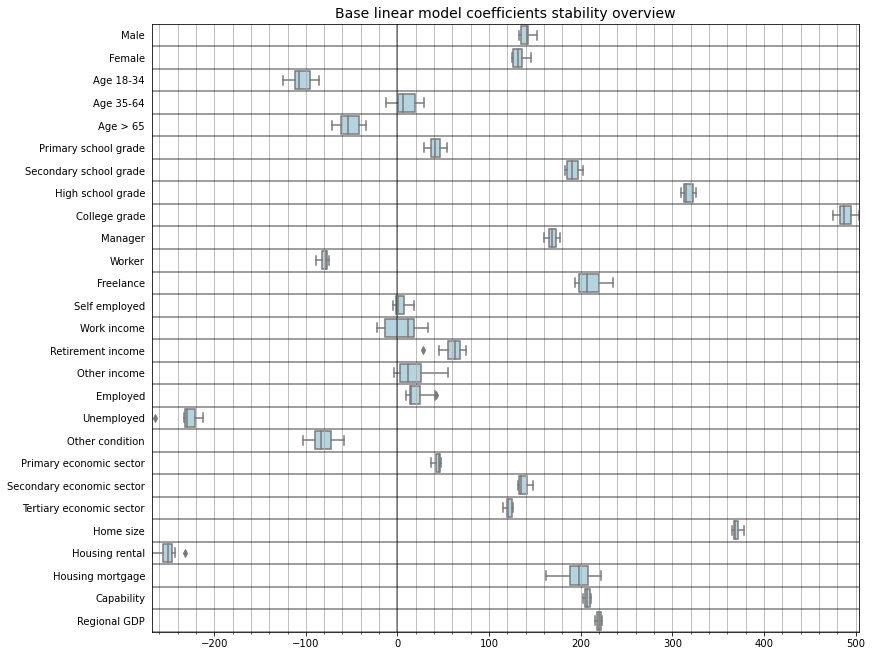

In [15]:
# Linear model 1 coefficients stability check

data = [np.round(cv_results1['estimator'][i]['LR'].coef_, 2) for i in range(len(cv_results1['estimator']))]


df_coeff = pd.DataFrame(
    data = data,
    columns = df_data_copy[features].columns,
)

plt.figure(figsize = (12,9), constrained_layout = True)
sns.boxplot(data = df_coeff, orient = 'h', whis = 1.5, color = 'lightblue')
plt.axvline(0, color = 'black', alpha = 0.5)
plt.hlines(
    y = np.arange(0.5, len(df_data_copy[features].columns) + 0.5, 1),
    xmin = np.array(data).min(),
    xmax = np.array(data).max(),
    colors = 'black',
    alpha = 0.5,
)
plt.xlim(np.array(data).min(), np.array(data).max())
plt.minorticks_on()
plt.tick_params(axis = 'y', which = 'both', width = 0)
plt.grid(which = 'both', axis = 'x')
plt.title('Base linear model coefficients stability overview', size = 14)

plt.show()

We can assume now that the baseline linear model is stable and provides conistent results independently from the data.

Below we provide the R Squared score of this model when we use the entire dataset for training. We will use this metric for future confrontations between the other models.

In [16]:
# Linear model 1 performance using entire dataset

Linear_model_1.fit(X, y)

print(line_sep)
print('Model accuracy when trained on all data:')
print('R squared = {:.3f}'.format(Linear_model_1.score(X, y)))
print(line_sep)

------------------------------------------------------------------
Model accuracy when trained on all data:
R squared = 0.405
------------------------------------------------------------------


We think that, an R score over 0.4 with a linear regression model that tries to explain human behaviour, is an unexpectedly good result.

### *Polynomial regression model*

Let's see if we can improve the accuracy adding polynoimial features while mantaining a well generalized and stable model as the prevoious one.

Below a report of the R score results of the eight cross validation istances using second degree polynomial features:

In [17]:
# Linear model 2 stability check with cross folds

start = time.time()

# Poly settings
Linear_model_2 = Pipeline([
    ('PolynomialFeatures', PolynomialFeatures(degree = 2)),
    ('LR', LinearRegression()),
])

cv_results2 = cross_validate(Linear_model_2, X, y, cv = cv, n_jobs = -1, scoring = 'r2', return_estimator = True)

print(line_sep)
print("Analisys completed in {:.2f} seconds.".format(time.time() - start))
print(line_sep)
df_scores = pd.DataFrame(columns = ['R squared'], data = cv_results2['test_score'])
df_scores.index.name = 'Fold'
df_scores.describe()

------------------------------------------------------------------
Analisys completed in 2.93 seconds.
------------------------------------------------------------------


,R squared
count,8.000000
mean,0.409203
std,0.023084
min,0.384976
25%,0.392100
50%,0.402792
75%,0.421487
max,0.446043


and third degree polynomial features:

In [18]:
# Linear model 2.1 stability check with cross folds

start = time.time()

# Poly settings
Linear_model_21 = Pipeline([
    ('PolynomialFeatures', PolynomialFeatures(degree = 3)),
    ('LR', LinearRegression()),
])

cv_results21 = cross_validate(Linear_model_21, X, y, cv = cv, n_jobs = -1, scoring = 'r2', return_estimator = True)

print(line_sep)
print("Analisys completed in {:.2f} seconds.".format(time.time() - start))
print(line_sep)
df_scores = pd.DataFrame(columns = ['R squared'], data = cv_results21['test_score'])
df_scores.index.name = 'Fold'
df_scores.describe()

------------------------------------------------------------------
Analisys completed in 115.96 seconds.
------------------------------------------------------------------


,R squared
count,8.000000e+00
mean,-9.144548e+16
std,1.760197e+17
min,-5.136693e+17
25%,-6.374389e+16
50%,-1.362844e+16
75%,-6.082106e+15
max,-4.861306e+15


We can immediately see that, while the second degree model gives consistent and positive results, the third degree model provides negative R scores across all eight folds which basically means that the model itself is worse than the intercept constant model.

Discarded the third degree model, let's focus on the second degree one by looking at its coefficients variability among the eight cross folds instances.

For each coefficient, the variability between the eight cross validation istances has been calculated with the standard deviation formula and, in the table below, we can see the summary statistics.

In [19]:
# Linear model 2 coefficients stability check

coeff_2 = np.array([cv_results2['estimator'][i]['LR'].coef_ for i in range(len(cv_results2['estimator']))]).T

Linear_model_2.fit(X, y)

df_coeff_2 = pd.DataFrame(
    data = np.array([np.std(coeff_2, axis = 1)]).T,
    index = Linear_model_2['PolynomialFeatures'].get_feature_names(features),
    columns = ['St_Dev']
).sort_values(by = 'St_Dev', axis = 0, ascending = False)

df_coeff_2.describe()

,St_Dev
count,4.060000e+02
mean,5.092216e+12
std,7.660989e+12
min,0.000000e+00
25%,4.210688e+01
50%,1.289896e+02
75%,8.619955e+12
max,3.558927e+13


We can clearly see that this model does not capture well the generalized relation between features and target. Indeed, half of the coefficients have very high variability with standard deviations between the hundreds and the trillions. This means that, if the data vary, also the coefficients vary and this clearly denotes that we cannot trust this model results because it tends to be overfitted.

### *Regularized polynomial regression model*

In this section we will use regularization to pursue a mitigation of the overfitting problem of the previous model and, hopefully a better model accuracy than the baseline linear regression.

For this task we will use Elastic Net, a regularized regression method that linearly combines the L1 and L2 penalties on the coefficients of the Lasso and Ridge methods.

As a first step we need to evaluate the hyperparameters involved in Elastic Net regression algorithm: the constant that multiplies the penalty terms $\alpha$ and the mixing parameter $\lambda$. The latter may vary between zero and one: for $\lambda = 0$  the penalty is a full L2 penalty (Ridge); for $\lambda = 1$  the penalty is a full L1 penalty (Lasso)

To do so, we will cross validate the model using the same eight folds used untill now and iterating the process with different values of $\alpha$ and $\lambda$.<br>
For each cross validation instances we will keep track of mean squared error (MSE) averaged on the eight cross folds to find the combination of hyperparameters that minimize it.

Below a brief summary of the process results.

In [20]:
# Linear model 3 find optimal regularization parameters with ElasticNetCV

start = time.time()

# Poly settings

# ElasticNetCV settings
alphas = np.linspace(0.1, 5, 21)
l1_ratios = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99, 1]

Linear_model_3 = Pipeline([
            ('PolynomialFeatures', PolynomialFeatures(degree = 2)),
            ('ElasticNetCV', ElasticNetCV(alphas = alphas, l1_ratio = l1_ratios, max_iter = 1000000, cv = cv, n_jobs = -1))
])

Linear_model_3.fit(X, y)

print(line_sep)
print("Analisys completed in {:.2f} seconds.".format(time.time() - start))
print('Best Alpha = {:.3f}'.format(Linear_model_3['ElasticNetCV'].alpha_))
print('Best L1 Ratio = {:.3f}'.format(Linear_model_3['ElasticNetCV'].l1_ratio_))
print(line_sep)

------------------------------------------------------------------
Analisys completed in 32.18 seconds.
Best Alpha = 1.080
Best L1 Ratio = 1.000
------------------------------------------------------------------


In the 3D plot below we can see how the MSE vary as a function of $\alpha$ and $\lambda$.

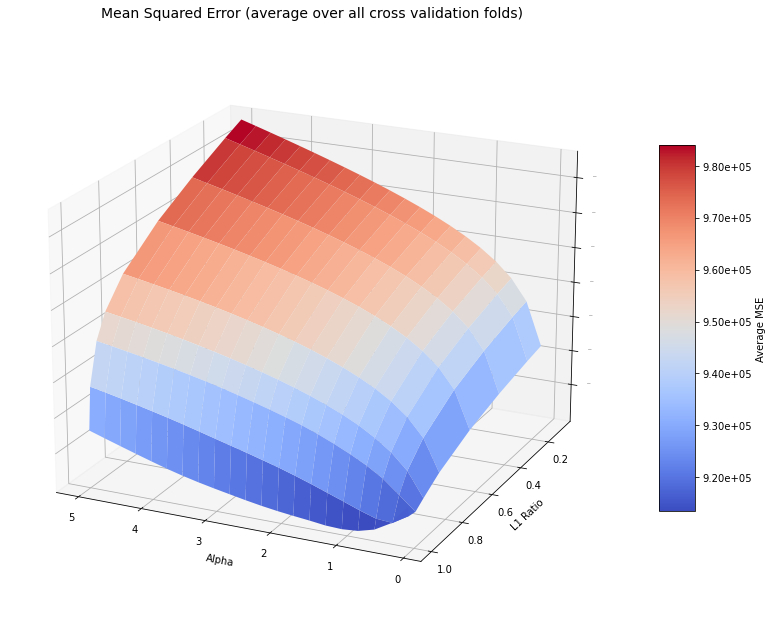

In [21]:
# plot average MSE against regularization parameters

x_plot, y_plot = np.meshgrid(alphas, l1_ratios)
z_plot = np.mean(np.flip(Linear_model_3['ElasticNetCV'].mse_path_, axis = 1), axis = 2)

fig = plt.figure(figsize = (12, 9), tight_layout = True)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    x_plot, y_plot, z_plot, 
    cmap = cm.coolwarm,
    linewidth = 0,
    antialiased = True,
)

ax.set_xlabel('Alpha')
ax.set_ylabel('L1 Ratio')
ax.zaxis.set_major_formatter('{x:.1e}')
ax.set_title('Mean Squared Error (average over all cross validation folds)', size = 14)
ax.tick_params(axis = 'z', labelsize = 0)

fig.colorbar(
    mappable = surf,
    shrink = 0.6,
    aspect = 10,
    label = 'Average MSE',
    format = '%.2e',
)

ax.view_init(20, 115)
plt.show()


Since the mixing parameter equate one, we will proceed with Lasso regularization, performing a further iteration process to find a more precise $\alpha$ from a narrower range.

Below a brief report and a plot of the MSE as a function of $\alpha$ showing its optimal value.

------------------------------------------------------------------
Analisys completed in 9.85 seconds.
Best Alpha = 1.068
------------------------------------------------------------------


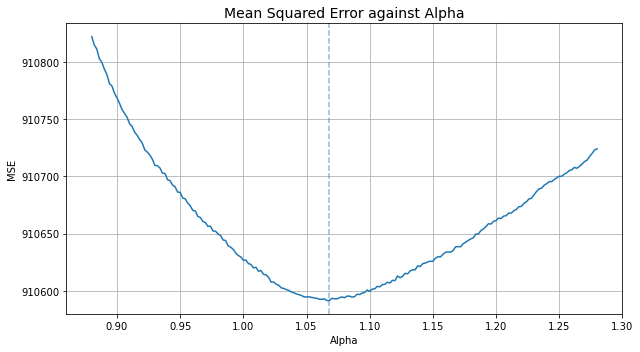

In [22]:
# Linear model 3.1 pinpoint best alpha with Lasso

start = time.time()

# Poly settings
degree = 2
alphas = np.linspace(
    Linear_model_3['ElasticNetCV'].alpha_ - 0.2,
    Linear_model_3['ElasticNetCV'].alpha_ + 0.2,
    201
)

# LassoCV settings
Linear_model_31 = Pipeline(
    [('PolynomialFeatures', PolynomialFeatures(degree = degree)),
    ('LassoCV', LassoCV(alphas = alphas, max_iter = 100000, cv = cv, n_jobs = -1))]
)
Linear_model_31.fit(X, y)

print(line_sep)
print("Analisys completed in {:.2f} seconds.".format(time.time() - start))
print("Best Alpha = {:.3f}".format(Linear_model_31['LassoCV'].alpha_))
print(line_sep)

plt.figure(figsize = (9, 5), tight_layout = True)
sns.lineplot(
    x = Linear_model_31['LassoCV'].alphas_,
    y = np.mean(Linear_model_31['LassoCV'].mse_path_, axis = 1),
)
plt.axvline(x = Linear_model_31['LassoCV'].alpha_, linestyle = '--', alpha = 0.5)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Mean Squared Error against Alpha', size = 14)
plt.grid()
plt.show()

Now that we have calculated the optimal hyperparameters, we can focus on assessing the model stability.

In the table below we can see how the R score performs between the eight cross validation folds.

In [23]:
# Linear model 3.2 check model score stability with cross folds

start = time.time()

# Poly settings
degree = 2
alpha = Linear_model_31['LassoCV'].alpha_

# LassoCV settings
Linear_model_32 = Pipeline(
    [('PolynomialFeatures', PolynomialFeatures(degree = degree)),
    ('Lasso', Lasso(alpha = alpha, max_iter = 100000))]
)

cv_results32 = cross_validate(Linear_model_32, X, y, cv = cv, n_jobs = -1, scoring = 'r2', return_estimator = True)

print(line_sep)
print("Analisys completed in {:.2f} seconds.".format(time.time() - start))
print(line_sep)

df_scores = pd.DataFrame(columns = ['R squared'], data = cv_results32['test_score'])
df_scores.index.name = 'Fold'
df_scores.describe()

------------------------------------------------------------------
Analisys completed in 41.02 seconds.
------------------------------------------------------------------


,R squared
count,8.000000
mean,0.418304
std,0.021350
min,0.395173
25%,0.403767
50%,0.411923
75%,0.427483
max,0.451639


We can see an analogue situation as the baseline linear model with consistent and, overall, higher results.

As done previously, for each of the 406 coefficients the standard deviation between the eight cross fold validation instances is computed. With these information, summarized in the table below, we can see how the coefficients vary as a function of the training and testing data.

In [24]:
# Linear model 3.2 coefficients stability check

coeff_32_cv = np.array([cv_results32['estimator'][i]['Lasso'].coef_ for i in range(len(cv_results32['estimator']))]).T

df_coeff_32_cv = pd.DataFrame(
    data = np.array([np.std(coeff_32_cv, axis = 1)]).T,
    columns = ['St_Dev']
).sort_values(by = 'St_Dev', axis = 0, ascending = False)

df_coeff_32_cv.describe()

,St_Dev
count,406.000000
mean,7.473241
std,8.981743
min,0.000000
25%,1.285034
50%,5.696745
75%,10.239112
max,97.539752


The above information confirms that this third model is stable and well generalized as the largest coefficient variation, as a funcion of the data, is contained under one hundred, from the trillions of the non regulated second degree polynomial model. Less than one hundred is a rather good value, considering that is correlated with a monthly spend that has a mean of 2.377,90 €/month and maximum variability of the features is between zero and six. To note also that 75% of the coefficients standard deviations is at ten or below.

Since we can trust this model, let's calculate its final accuracy when trained using the entire dataset.

In [25]:
# Linear model 3.2 performance: using entire dataset

start = time.time()

# LassoCV settings

Linear_model_32.fit(X, y)

print(line_sep)
print(
    'Model accuracy when trained on all data with alpha = {:.3f}:'.format(
        alpha,
    )
)
print('R squared = {:.3f}'.format(Linear_model_32.score(X, y)))
print('R squared incement over baseline model = {:.1f} %'.format((Linear_model_32.score(X, y)-Linear_model_1.score(X, y))/Linear_model_1.score(X, y) * 100))

print(line_sep)

------------------------------------------------------------------
Model accuracy when trained on all data with alpha = 1.068:
R squared = 0.435
R squared incement over baseline model = 7.5 %
------------------------------------------------------------------


From the brief report above, we can also see an increase in accuracy respect the baseline model.

## Recommended regression models

As we saw, with the polynomial feature and regularization, we couldn't boost the model accuracy sensibly higher than the baseline linear regression model. So with an accuracy penalty of only 7.5%, we think it's better to rely on the first model for an interpretation purpose. Indeed, interpreting the baseline model involves the analysis of only 27 coefficients, rather than the 406 of the regularized polynomial model.

In the next paragraph we will analyze the linear regression coefficients to get insights on which are the most determining factors correlated to the italian families spending power.<br>

Nevertheless, we have to realize that, with all that done till now, the R Squared scores tell us that these linear model variations explain barely an half of the the spending power trend.

## Key findings and insights

As we know, the linear model coefficients can be interpreted as the force of the feature, thay are multiplied for, in the determination of the target variable trend.

Thus, representing the coefficients as a bar plot as done below, we can obtain a well readable "force plot". Better interpretability is also achieved, because of the choose to not apply a scale to the target variable.

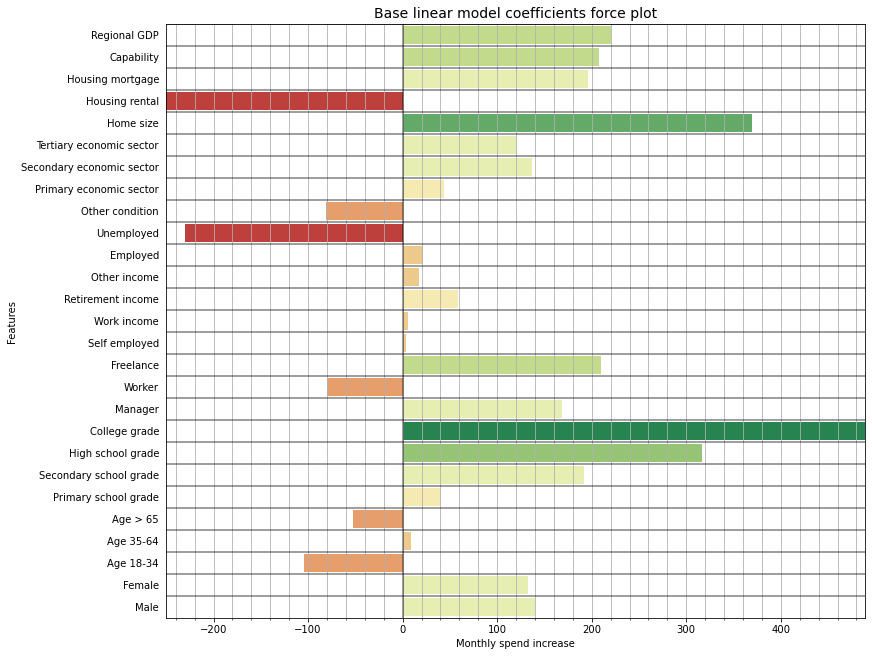

In [26]:
# Linear model 1 model interpretation: coefficients "force plot"

pal = sns.color_palette("Greens_d", len(Linear_model_1['LR'].coef_))
plt.figure(frameon = False, figsize = (12,9), constrained_layout = True)
sns.barplot(
    y = features,
    x = Linear_model_1['LR'].coef_,
    orient = 'h',
    palette = colors_func(Linear_model_1['LR'].coef_, 'RdYlGn', 10)
)
plt.axvline(0, color = 'black', alpha = 0.5)
plt.minorticks_on()
plt.tick_params(axis = 'y', which = 'both', width = 0)
plt.grid(which = 'both', axis = 'x')
plt.hlines(
    y = np.arange(0.5, len(df_data_copy[features].columns) + 0.5, 1),
    xmin = Linear_model_1['LR'].coef_.min(),
    xmax = Linear_model_1['LR'].coef_.max(),
    colors = 'black',
    alpha = 0.5,
)
plt.xlim(Linear_model_1['LR'].coef_.min(), Linear_model_1['LR'].coef_.max())
plt.ylim(- 0.5, len(df_data_copy[features].columns) - 0.5)
plt.ylabel('Features')
plt.xlabel('Monthly spend increase')
plt.title('Base linear model coefficients force plot', size = 14)
plt.show()

As we expected, we can see how the Regional GDP of the area the family is located, increase the family spend itself. Moreover, since we have scaled this variable from zero to three, we can see how the model predicts that families located in the richest areas of the country (so Regional GDP rated at 3) have a monthly spend increase of over 600€/month.

Also the percepted economic capability positively contribute to the family spend in a similar dimension as previously seen, and that is also expectable.

Looking at the home related features we can see how the size positively affect the spend and it is one of the most affecting factors modeled.<br>
Curiously, we see a different direction of the spend increment if the family is on mortgage or rent. We can interpret this information considering that usually richer families tend to choose a mortgage instead of a rent.<br> As we noted previously, mortgage and rent money exit are not part of the target variable value; so it is really curious that the model predicts an increased spend for families that are on mortgage respect those that already own their living place without any money exit (so zero rent and zero mortgage).

Focusing on the economic sectors, we can observe how there is always an increase of spend for every member involved in any of them and more for the secondary and tertiary sector. Again this is expected.

For the working condition, we think the model correctly predicts a huge loss of spending power for every unemployed family member and a smaller loss for members that have "other" conditions that do not generate an income, for example: housewife or student.

Coming to the income features, it is not surprising that retirement positively affect the spend more than work income. Maybe, here we can read a decline tendency in the last decades, with lesser and lesser opportunities for the youngers?

Checking the occupation type group of features, as expected, we see notable increments in the spending power for every freelance (this category includes also entrepreneurs) and manager in the family rather than worker and self employed worker.

The model outcome concerning the impact of education levels of the family members is also very expectable and does not need further notes.

Concerning the age related features, we can see an overall negative impact for the ranges considered, a part from a marginal increase in the "35-64" range. This means that for every member in the range "below 18", feature which we have removed, we certainly have an increase of the family spend.

Finally, the members sex features, that give us also the overall family size, tell us that a family size increase always increments also the spend and there is almost no difference in how much the sexes contribute to this.

## Suggestions

In this paragraph we better inspect the limit of the proposed model.

Considering the second degree polynomial lasso regularized model, which is the most accurate so far, below we can see the predicted against actual spend values plot.

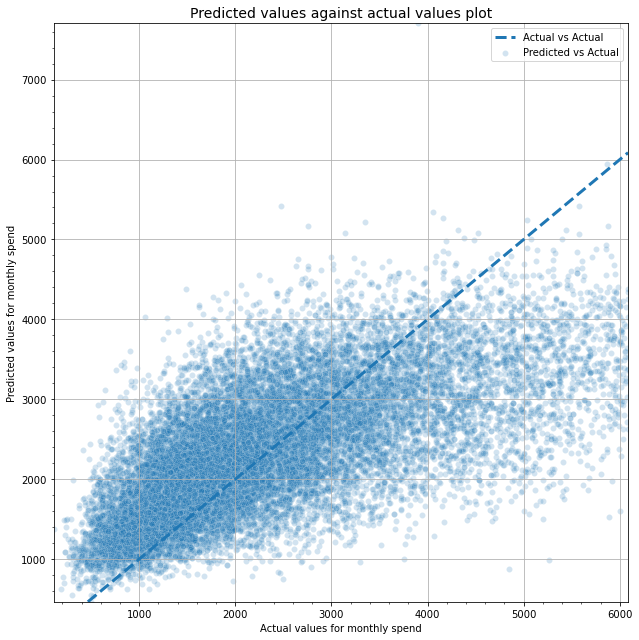

In [27]:
# Linear model 3.2 performance: predicted vs actual plot

y_hat = Linear_model_32.predict(X)

plt.figure(figsize = (9, 9), tight_layout = True)
sns.scatterplot(
    x = y,
    y = y_hat,
    alpha = 0.2,
    label = 'Predicted vs Actual',
)
plt.axline(
    xy1 = (0, 0),
    slope = 1,
    label = 'Actual vs Actual',
    ls = '--',
    lw = 3,
)
plt.xlim(y.min(), y.max())
plt.ylim(y_hat.min(), y_hat.max())
plt.legend()
plt.title('Predicted values against actual values plot', size = 14)
plt.xlabel('Actual values for monthly spend')
plt.ylabel('Predicted values for monthly spend')
plt.grid()
plt.minorticks_on()

plt.show()

We can clearly see a pattern since the distributions of the predictions is not randomly spread above and below the 45 degrees dashed line which represent the actual data. Precisely, they are more present above the line for lower actual spend and under the line for higher values.

A better view of this pattern is better shown in the residual plot below.

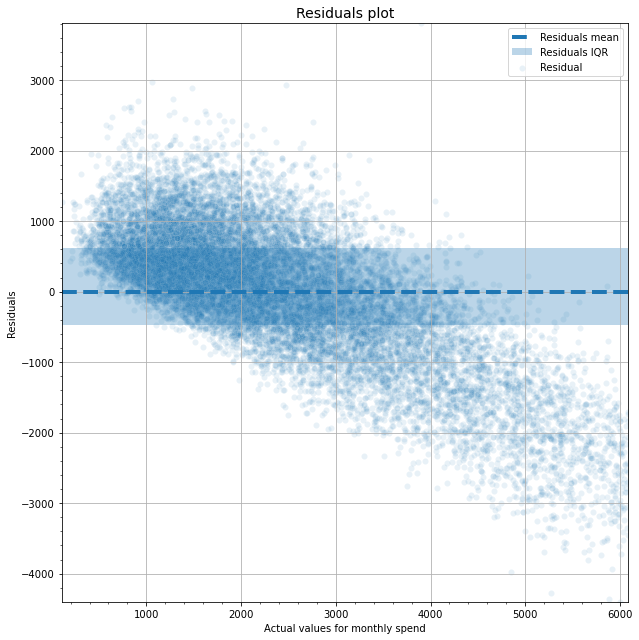

In [28]:
# Linear model 3.2 performance: using prediction error vs actual plot

from matplotlib.patches import Rectangle

y_hat = Linear_model_32.predict(X)
y_error = y_hat - y


fig = plt.figure(figsize = (9, 9), tight_layout = True)
ax = plt.axes()

# fig, ax = plt.subplots()

sns.scatterplot(
    x = y,
    y = y_error,
    alpha = 0.1,
    label = 'Residual',
    ax = ax,
)
plt.axhline(
    y = np.mean(y_error),
    ls = '--',
    label = 'Residuals mean',
    lw = 4,
)

ax.add_patch(
    Rectangle(
        (y.min(),np.quantile(y_error, 0.25)),
        y.max() - y.min(),
        np.quantile(y_error, 0.75) - np.quantile(y_error, 0.25),
        alpha = 0.3,
        label = 'Residuals IQR'
    ),
)

plt.xlim(y.min(), y.max())
plt.ylim(y_error.min(), y_error.max())
plt.legend()
plt.title('Residuals plot', size = 14)
plt.xlabel('Actual values for monthly spend')
plt.ylabel('Residuals')
plt.grid()
plt.minorticks_on()


plt.show()

Here we can see that our model, as it should be, is unbiased (error mean is zero) and homoscedastic (error variance is about constant for every value of the actual spend). Unfortunately the error is not uncorrelated and we clearly see that the model underestimate and overestimate the family spend for lower and higher actual spend respectively.

This basically means that the error itself contains useful information that our model didn't manage to capture and explains the overall low R Squared value.

To address this situation we could add more features that unfortunately are not captured in the source dataset. For example we don't have any info on the overall family income which could alone explain a lot of the family spend.

We could also try to use a different machine learning method that could deal better with the complexity of the subject.